In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import glob
import string
import statistics
from os.path import exists
from scipy.stats import norm
from scipy.stats import zscore
from scipy.stats import pearsonr  
from scipy.stats import chisquare
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import math
import scipy.stats as stats

In [2]:
## define snodgrass correction and dprime calculation
def snodgrass(num,denom):
    return (float(num)+.5) / (float(denom) +1)

def dprime(hit,fa):
    return norm.ppf(hit,loc=0,scale=1) - norm.ppf(fa,loc=0,scale=1)

In [3]:
## Code taken from Craig Stark to find lines for the beginning of the study and test phases

def findlines(filename):
    s_starts=[]
    t_starts=[]
    with open(filename) as file:
        for linenum, linetxt in enumerate(file,1):
            if "Study phase started at" in linetxt:
                s_starts.append(linenum)
            elif "Test phase started at" in linetxt:
                t_starts.append(linenum)
    return (s_starts, t_starts)

In [4]:
def targ_trials(data):
    ## calculate number of Target Trials
    #initialize number of target trials to zero
    num_targ_trials = 0
    #loop through the data and add one if the condition is T (target) and the RT is greater than 400ms (avoid trials that cannot be real responses)
    for d in range(len(data)):
        if (data.loc[d, 'Cond'] == 'T') & (data.loc[d, 'RT'] >400):
            num_targ_trials +=1
    return num_targ_trials

In [5]:
def foil_trials(data):
        ## calculate number of Foil Trials
    #initialize number of foil trials to zero
    num_foil_trials = 0
    #loop through the data and add one to the number of new trials if the condition is F (foil) & RT is greater than 400
    for g in range(len(data)):
        if (data.loc[g, 'Cond'] == 'F') & (data.loc[g, 'RT'] > 400):
            num_foil_trials +=1
    return num_foil_trials

In [6]:
def lure_trials(data):
        ## calculate number of Lure Trials
    #initialize number of lure trials to zero
    num_lure1 = 0
    num_lure2 = 0
    num_lure3 = 0
    num_lure4 = 0
    num_lure5 = 0
    #loop through the data and add one to the number of lure trials if the condition is L (Lure) AND "real" response
    for f in range(len(data)):
        if (data.loc[f, 'Cond'] == 'L') & (data.loc[f, 'RT'] > 400):
            if data.loc[f, 'LBin'] == 1:
                num_lure1 +=1
            elif data.loc[f, 'LBin'] == 2:
                num_lure2 +=1
            elif data.loc[f, 'LBin'] == 3:
                num_lure3 +=1
            elif data.loc[f, 'LBin'] == 4:
                num_lure4 +=1
            elif data.loc[f, 'LBin'] == 5:
                num_lure5 +=1
    return num_lure1, num_lure2, num_lure3, num_lure4, num_lure5

In [7]:
def no_resp(data):
     ## calculate total number of no response
    
     ## calculate number of no responses to Targets

    #initialize number of no responses to targets to zero
    num_nr_targ = 0
    #loop through the data and add one to number of no responses to targets
    #if the response is 0 (no response) and the condition is T (target);
    for a in range(len(data)):
        if (data.loc[a, 'Resp'] ==0) & (data.loc[a, 'Cond'] == 'T'):
            num_nr_targ +=1

    ## calculate number of no responses to Foils

    #initialize number of no responses to foils to zero
    num_nr_foil = 0
    #loop through the data and add one to the number of no responses to foils
    #if the response is 0 (no response) and the condition is F (foil)
    for c in range(len(data)):
        if (data.loc[c, 'Resp'] == 0) & (data.loc[c,'Cond'] == 'F'):
            num_nr_foil+=1
            
             ## calculate number of no responses to Lures

    #initialize number of no responses to lures to zero
    num_nr_lure1 = 0
    num_nr_lure2 = 0
    num_nr_lure3 = 0
    num_nr_lure4 = 0
    num_nr_lure5 = 0
    #loop through the data and add one to the number of no responses to lures 
    #if the response is 0 (no response) and the condition is L (Lure)
    for b in range(len(data)):
        if (data.loc[b, 'Resp'] == 0) & (data.loc[b, 'Cond'] =='L'):
            if data.loc[b, 'LBin' == 1]:
                num_nr_lure1 +=1
            elif data.loc[b, 'LBin' == 2]:
                num_nr_lure2 +=1
            elif data.loc[b, 'LBin' == 3]:
                num_nr_lure3 +=1
            elif data.loc[b, 'LBin' == 4]:
                num_nr_lure4 +=1
            elif data.loc[b, 'LBin' == 5]:
                num_nr_lure5 +=1
                
            

    # return the number of no responses overall, to targets, to lures, to foils, and the proportion of NR overall
    return num_nr_targ, num_nr_foil, num_nr_lure1, num_nr_lure2, num_nr_lure3, num_nr_lure4, num_nr_lure5

In [8]:
def targ_resp(data):
    ## calculate number of target trials using function defined above
    num_targ_trials = targ_trials(data)
    ## calculate number of Old|Target

    #initialize the number of Target|Old to zero
    num_old_targ = 0
    #loop through the data and add one to the number of of Old|Target 
    #if the condition is T (target) and if the response is 1 (Old) & RT is greater than 400
    for j in range(len(data)):
        if ((data.loc[j, 'Cond'] == 'T') & (data.loc[j, 'Resp'] == 1) & (data.loc[j, 'RT']>400)):
            num_old_targ +=1

    ## Calculate proportion of Old|Target for ALL Target Trials

    #Divide the number of old|target by the total number of target trials
    prop_old_targ = num_old_targ/num_targ_trials
    
    ## Calculate number of Similar|Target

    #initialize the number of Similar|Target to zero
    num_sim_targ = 0

    #loop through the data and add one to the number of Similar|Target 
    #if the condition is T (target) and if the participant responsed 2 (Similar) & RT is greater than 400
    for k in range(len(data)):
        if ((data.loc[k, 'Cond']=='T') & (data.loc[k, 'Resp']==2) &(data.loc[k, 'RT']>400)):
            num_sim_targ+=1

    ## calculate proportion of Similar|target for all target trials

    #divide the number of Similar|target by the total number of target trials
    prop_sim_targ= num_sim_targ/num_targ_trials

    ## calculate number of New|Target

    # initialize the number of New|Target to zero
    num_new_targ = 0
    #loop through the data and add one to the number of New|Target
    #if the condition is T(Target) and if the participant responded 3(New) & RT is greater than 400
    for l in range(len(data)):
        if ((data.loc[l, 'Cond'] == 'T') & (data.loc[l, 'Resp'] == 3) & (data.loc[l, 'RT']>400)):
            num_new_targ+=1
    
    ## calculate the proportion of New|Target for all target trials

    #divide number of New|Target by the total number of target trials
    prop_new_targ = num_new_targ/num_targ_trials
   
    # return the number and proportion of each response type for targets
    return num_old_targ, prop_old_targ, num_sim_targ, prop_sim_targ, num_new_targ, prop_new_targ

In [9]:
def foil_resp(data):
    ## calculate number of foil trials using function defined above
    num_foil_trials = foil_trials(data)
      ## calculate number of Old|Foil
     #Initialize the number of Old|Foil
    num_old_foil = 0
    #loop throught the data and add one to the number of Old|Foil
    #if the condition is F (Foil) and the participant responded 1 (Old) &  RT is greater than 400
    for q in range(len(data)):
        if ((data.loc[q, 'Cond'] == 'F') & (data.loc[q, 'Resp'] == 1) &(data.loc[q, 'RT']>400)):
            num_old_foil+=1

    ## calculate proportion of old|foil for all foil trials

    #divide number of old|foil by the total number of foil trials
    prop_old_foil = num_old_foil/num_foil_trials
    
    ##calculate number of Similar|Foil

    #Initialize the number of Similar|Foil to zero
    num_sim_foil = 0
    #loop through the data and add one to the number of Similar|Foil
    #if the condition is F(Foil) and the participant responded 2(similar) &  RT is greater than 400
    for r in range(len(data)):
        if ((data.loc[r, 'Cond'] == 'F') & (data.loc[r, 'Resp'] == 2) & (data.loc[r, 'RT']>400)):
            num_sim_foil+=1

      ## calculate proportion of similar|foil for all foil trials

    #divide the number of similar|foil by the number of foil trials
    prop_sim_foil = num_sim_foil/num_foil_trials
    
    ##calculate nummber of New|Foil

    #Initialize the number of New|Foil to zero
    num_new_foil = 0
    #Loop through the data and add one to the number of New|Foil
    #if the condition is F(Foil) and the participant responded 3(New) &  RT is greater than 400
    for s in range(len(data)):
        if ((data.loc[s, 'Cond'] == 'F') & (data.loc[s, 'Resp'] == 3) & (data.loc[s, 'RT']>400)):
            num_new_foil+=1

   
    
    
    ## calculate proportion of new|foil for all foil trials 

    #divide the number of new|foil by the total number of foil trials
    prop_new_foil = num_new_foil/num_foil_trials

    #return the number and proportion of each response type to foil trials
    return num_old_foil, prop_old_foil, num_sim_foil, prop_sim_foil, num_new_foil, prop_new_foil

In [10]:
def lure_resp(data):
    num_lure_trials = lure_trials(data)
    ## calculate number of Old|Lure using function defined above

    #Initialize the number of Old|Lure to zero
    num_old_lure = 0
    #loop through the data and add one to the number of Old|Lure 
    # if the condition is L (Lure) and the participant responded 1 (Old) & RT is greater than 400
    for m in range(len(data)):
        if ((data.loc[m, 'Cond']=='L') & (data.loc[m, 'Resp'] == 1) & (data.loc[m, 'RT']>400)) :
            num_old_lure+=1
   
    ## calculate the proportion of Old|Lure for all lure trials

    #divide number of Old|Lure by the total number of lure trials
    prop_old_lure = num_old_lure/num_lure_trials
    
       ## calculate number of Similar|Lure

    #Initialize the number of Similar|Lure to zero
    num_sim_lure = 0
    #loop through the data and add one to the number of Similar|Lure
    #if the condition is L (Lure) and the participant responded 2 (Similar) &  RT is greater than 400
    for o in range(len(data)):
        if ((data.loc[o, 'Cond']=="L") & (data.loc[o, 'Resp'] == 2) & (data.loc[o, 'RT']>400)):
            num_sim_lure+=1

    ## Calculate the proportion of Similar|Lure for all lure trials

    #divide number of Similar|Lure by the total number of lure trials
    prop_sim_lure = num_sim_lure/num_lure_trials
    
    ## calculate number of New|Lure

    #Initialize the number of New|Lure to zero
    num_new_lure = 0
    #loop through the data and add one to the number of New|Lure
    #if the condition is L(Lure) and the participant responded 3 (New) & RT is greater than 400
    for p in range(len(data)):
        if ((data.loc[p, 'Cond']=='L') & (data.loc[p, 'Resp']== 3) & (data.loc[p, 'RT']>400)):
            num_new_lure+=1

    ## calculate proportion of new|lure for all lure trials

    #divide number of new|lure by the total number of lure trials
    prop_new_lure = num_new_lure/num_lure_trials
    
    #return the number and proportion of each response type to lures

    return num_old_lure, prop_old_lure, num_sim_lure, prop_sim_lure, num_new_lure, prop_new_lure

In [11]:
## create a long-format data frame
data_long=pd.DataFrame()
n_stim_per=64
study_len = n_stim_per*2
test_len = n_stim_per*3
#read in sheet with demographics & NP scores
demo_data = pd.read_csv('/Users/madisonhunt/Desktop/Oak/stark_task/stark_demographics.csv')
pidn_list = demo_data['pidn']
#forloop through pidns and adjust the filename based on nomenclature changes throughout the study
for pidn in pidn_list:
    if pidn != 999 and pidn !=685:
        if pidn < 685:
            filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/BPSOlog_0{}.txt'.format(pidn)
           
        if pidn > 685:
            if pidn < 1000:
#         elif pidn > 685 and pidn <1000:
                filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/MSTlog_0{}.txt'.format(pidn)
                
            else:
                filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/MSTlog_{}.txt'.format(pidn)
                
# read in files using Craig Stark's code
        if exists(filename):

            s_starts, t_starts = findlines(filename)
            if len(s_starts) & len(t_starts):
                study_starts = s_starts[-1]
                test_starts = t_starts[-1]
                pt_data =  pd.read_csv(filename, delimiter="\t", skiprows= test_starts, nrows=test_len, header = 0)     

                pt_data['pidn'] = pidn
                
                data_long = data_long.append(pt_data,ignore_index=True)
#remove participants who were excluded for having low old/new d'
data_long=data_long[(data_long['pidn']!=528) &(data_long['pidn']!=866) &(data_long['pidn']!=1230)]

 ## remove any trials below 400 ms
data_long_with_nr=data_long.copy()
data_long=data_long[data_long['RT']>400]

data_long=data_long.reset_index(drop=True)

In [12]:
## create summary data frame
summ_data = pd.DataFrame()
row = 0

## loop through the part
for pid in pd.unique(data_long['pidn']):
    summ_data.loc[row, 'pidn'] = pid
    pt_data = data_long[data_long['pidn'] == pid].reset_index(drop=True)
    pt_data_with_nr = data_long_with_nr[data_long_with_nr['pidn']==pid].reset_index(drop=True)
    summ_data.loc[row, 'trial_type'] = 'Target'
    summ_data.loc[row, 'num_trials'] = targ_trials(pt_data)
    
    summ_data.loc[row+1, 'pidn'] = pid
    summ_data.loc[row+1, 'trial_type'] = 'Foil'
    summ_data.loc[row+1, 'num_trials'] = foil_trials(pt_data)
    
    summ_data.loc[row+2, 'pidn'] = pid
    summ_data.loc[row+2, 'trial_type'] = 'Lure1'
    summ_data.loc[row+3, 'pidn'] = pid
    summ_data.loc[row+3, 'trial_type'] = 'Lure2'
    summ_data.loc[row+4, 'pidn'] = pid
    summ_data.loc[row+4, 'trial_type'] = 'Lure3'
    summ_data.loc[row+5, 'pidn'] = pid
    summ_data.loc[row+5, 'trial_type'] = 'Lure4'
    summ_data.loc[row+6, 'pidn'] = pid
    summ_data.loc[row+6, 'trial_type'] = 'Lure5'
    [summ_data.loc[row+2, 'num_trials'], summ_data.loc[row+3, 'num_trials'], summ_data.loc[row+4, 'num_trials'], summ_data.loc[row+5, 'num_trials'], summ_data.loc[row+6, 'num_trials']] = lure_trials(pt_data)

    summ_data.loc[row, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T') & (data_long['Resp']==1)])
    summ_data.loc[row+1, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F') & (data_long['Resp']==3)])
    summ_data.loc[row+2, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='L') & (data_long['LBin']==1) & (data_long['Resp']==2)])
    summ_data.loc[row+3, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='L') & (data_long['LBin']==2) & (data_long['Resp']==2)])
    summ_data.loc[row+4, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='L') & (data_long['LBin']==3) & (data_long['Resp']==2)])
    summ_data.loc[row+5, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='L') & (data_long['LBin']==4) & (data_long['Resp']==2)])
    summ_data.loc[row+6, 'num_correct'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='L') & (data_long['LBin']==5) & (data_long['Resp']==2)])
    
    summ_data.loc[row, 'prop_correct'] = summ_data.loc[row, 'num_correct']/summ_data.loc[row, 'num_trials']
    summ_data.loc[row+1, 'prop_correct'] = summ_data.loc[row+1, 'num_correct']/summ_data.loc[row+1, 'num_trials']
    summ_data.loc[row+2, 'prop_correct'] = summ_data.loc[row+2, 'num_correct']/summ_data.loc[row+2, 'num_trials']
    summ_data.loc[row+3, 'prop_correct'] = summ_data.loc[row+3, 'num_correct']/summ_data.loc[row+3, 'num_trials']
    summ_data.loc[row+4, 'prop_correct'] = summ_data.loc[row+4, 'num_correct']/summ_data.loc[row+4, 'num_trials']
    summ_data.loc[row+5, 'prop_correct'] = summ_data.loc[row+5, 'num_correct']/summ_data.loc[row+5, 'num_trials']
    summ_data.loc[row+6, 'prop_correct'] = summ_data.loc[row+6, 'num_correct']/summ_data.loc[row+6, 'num_trials']
    
    summ_data.loc[row, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['Cond']=='T') & (data_long_with_nr['Resp']==0)])
    summ_data.loc[row+1, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['Cond']=='F') & (data_long_with_nr['Resp']==0)])
    summ_data.loc[row+2, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['LBin']==1) & (data_long_with_nr['Resp']==0)])
    summ_data.loc[row+3, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['LBin']==2) & (data_long_with_nr['Resp']==0)])
    summ_data.loc[row+4, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['LBin']==3) & (data_long_with_nr['Resp']==0)])
    summ_data.loc[row+5, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['LBin']==4) & (data_long_with_nr['Resp']==0)])
    summ_data.loc[row+6, 'num_nr'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pid) & (data_long_with_nr['LBin']==5) & (data_long_with_nr['Resp']==0)])

    summ_data.loc[row, 'prop_nr'] = summ_data.loc[row, 'num_nr']/(summ_data.loc[row, 'num_nr']+ summ_data.loc[row, 'num_trials'])
    summ_data.loc[row+1, 'prop_nr'] = summ_data.loc[row+1, 'num_nr']/(summ_data.loc[row+1, 'num_nr']+ summ_data.loc[row+1, 'num_trials'])
    summ_data.loc[row+2, 'prop_nr'] = summ_data.loc[row+2, 'num_nr']/(summ_data.loc[row+2, 'num_nr']+ summ_data.loc[row+2, 'num_trials'])
    summ_data.loc[row+3, 'prop_nr'] = summ_data.loc[row+3, 'num_nr']/(summ_data.loc[row+3, 'num_nr']+ summ_data.loc[row+3, 'num_trials'])
    summ_data.loc[row+4, 'prop_nr'] = summ_data.loc[row+4, 'num_nr']/(summ_data.loc[row+4, 'num_nr']+ summ_data.loc[row+4, 'num_trials'])
    summ_data.loc[row+5, 'prop_nr'] = summ_data.loc[row+5, 'num_nr']/(summ_data.loc[row+5, 'num_nr']+ summ_data.loc[row+5, 'num_trials'])
    summ_data.loc[row+6, 'prop_nr'] = summ_data.loc[row+6, 'num_nr']/(summ_data.loc[row+6, 'num_nr']+ summ_data.loc[row+6, 'num_trials'])

    summ_data.loc[row, 'num_hits'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')&(data_long['Resp']==1)])
    summ_data.loc[row+1, 'num_hits'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')&(data_long['Resp']==3)])
    summ_data.loc[row+2, 'num_hits'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==2)])
    summ_data.loc[row+3, 'num_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==2)])
    summ_data.loc[row+4, 'num_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==2)])
    summ_data.loc[row+5, 'num_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==2)])
    summ_data.loc[row+6, 'num_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==2)])
    
    summ_data.loc[row, 'num_FA'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')&(data_long['Resp']==2)])
    summ_data.loc[row+1, 'num_FA'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')&(data_long['Resp']==1)])
    summ_data.loc[row+2, 'num_FA'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==1)])
    summ_data.loc[row+3, 'num_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==1)])
    summ_data.loc[row+4, 'num_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==1)])
    summ_data.loc[row+5, 'num_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==1)])
    summ_data.loc[row+6, 'num_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==1)])
    
    summ_data.loc[row, 'num_misses'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')&(data_long['Resp']==3)])
    summ_data.loc[row+1, 'num_misses'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')&(data_long['Resp']==2)])
    summ_data.loc[row+2, 'num_misses'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==3)])
    summ_data.loc[row+3, 'num_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==3)])
    summ_data.loc[row+4, 'num_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==3)])
    summ_data.loc[row+5, 'num_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==3)])
    summ_data.loc[row+6, 'num_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==3)])
    
    summ_data.loc[row, 'prop_hits'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')&(data_long['Resp']==1)])/summ_data.loc[row, 'num_trials']
    summ_data.loc[row+1, 'prop_hits'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')&(data_long['Resp']==3)])/summ_data.loc[row+1, 'num_trials']
    summ_data.loc[row+2, 'prop_hits'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==2)])/summ_data.loc[row+2, 'num_trials']
    summ_data.loc[row+3, 'prop_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==2)])/summ_data.loc[row+3, 'num_trials']
    summ_data.loc[row+4, 'prop_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==2)])/summ_data.loc[row+4, 'num_trials']
    summ_data.loc[row+5, 'prop_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==2)])/summ_data.loc[row+5, 'num_trials']
    summ_data.loc[row+6, 'prop_hits']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==2)])/summ_data.loc[row+6, 'num_trials']
    
    summ_data.loc[row, 'prop_FA'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')&(data_long['Resp']==2)])/summ_data.loc[row, 'num_trials']
    summ_data.loc[row+1, 'prop_FA'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')&(data_long['Resp']==1)])/summ_data.loc[row+1, 'num_trials']
    summ_data.loc[row+2, 'prop_FA'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==1)])/summ_data.loc[row+2, 'num_trials']
    summ_data.loc[row+3, 'prop_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==1)])/summ_data.loc[row+3, 'num_trials']
    summ_data.loc[row+4, 'prop_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==1)])/summ_data.loc[row+4, 'num_trials']
    summ_data.loc[row+5, 'prop_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==1)])/summ_data.loc[row+5, 'num_trials']
    summ_data.loc[row+6, 'prop_FA']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==1)])/summ_data.loc[row+6, 'num_trials']
    
    summ_data.loc[row, 'prop_misses'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')&(data_long['Resp']==3)])/summ_data.loc[row, 'num_trials']
    summ_data.loc[row+1, 'prop_misses'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')&(data_long['Resp']==2)])/summ_data.loc[row+1, 'num_trials']
    summ_data.loc[row+2, 'prop_misses'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==3)])/summ_data.loc[row+2, 'num_trials']
    summ_data.loc[row+3, 'prop_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==3)])/summ_data.loc[row+3, 'num_trials']
    summ_data.loc[row+4, 'prop_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==3)])/summ_data.loc[row+4, 'num_trials']
    summ_data.loc[row+5, 'prop_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==3)])/summ_data.loc[row+5, 'num_trials']
    summ_data.loc[row+6, 'prop_misses']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==3)])/summ_data.loc[row+6, 'num_trials']
    

    summ_data.loc[row+2, 'sep_bias'] = summ_data.loc[row+2, 'prop_hits'] - summ_data.loc[row+1, 'prop_misses']
    summ_data.loc[row+3, 'sep_bias'] = summ_data.loc[row+3, 'prop_hits'] - summ_data.loc[row+1, 'prop_misses']
    summ_data.loc[row+4, 'sep_bias'] = summ_data.loc[row+4, 'prop_hits'] - summ_data.loc[row+1, 'prop_misses']
    summ_data.loc[row+5, 'sep_bias'] = summ_data.loc[row+5, 'prop_hits'] - summ_data.loc[row+1, 'prop_misses']
    summ_data.loc[row+6, 'sep_bias'] = summ_data.loc[row+6, 'prop_hits'] - summ_data.loc[row+1, 'prop_misses']
    
    summ_data.loc[row, 'old_bias'] = 1-(summ_data.loc[row, 'prop_hits'] - summ_data.loc[row+1, 'prop_FA'])
    summ_data.loc[row+2, 'old_bias'] = 1-(summ_data.loc[row+2, 'prop_FA'] - summ_data.loc[row+1, 'prop_FA'])
    summ_data.loc[row+3, 'old_bias'] = 1-(summ_data.loc[row+3, 'prop_FA'] - summ_data.loc[row+1, 'prop_FA'])
    summ_data.loc[row+4, 'old_bias'] = 1-(summ_data.loc[row+4, 'prop_FA'] - summ_data.loc[row+1, 'prop_FA'])
    summ_data.loc[row+5, 'old_bias'] = 1-(summ_data.loc[row+5, 'prop_FA'] - summ_data.loc[row+1, 'prop_FA'])
    summ_data.loc[row+6, 'old_bias'] = 1-(summ_data.loc[row+6, 'prop_FA'] - summ_data.loc[row+1, 'prop_FA'])
    
    summ_data.loc[row, 'corrected_hits'] = summ_data.loc[row, 'prop_hits'] - summ_data.loc[row, 'prop_FA']
    summ_data.loc[row+1, 'corrected_hits'] = summ_data.loc[row+1, 'prop_hits'] - summ_data.loc[row+1, 'prop_FA']
    summ_data.loc[row+2, 'corrected_hits'] = summ_data.loc[row+2, 'prop_hits'] - summ_data.loc[row+2, 'prop_FA']
    summ_data.loc[row+3, 'corrected_hits'] = summ_data.loc[row+3, 'prop_hits'] - summ_data.loc[row+3, 'prop_FA']
    summ_data.loc[row+4, 'corrected_hits'] = summ_data.loc[row+4, 'prop_hits'] - summ_data.loc[row+4, 'prop_FA']
    summ_data.loc[row+5, 'corrected_hits'] = summ_data.loc[row+5, 'prop_hits'] - summ_data.loc[row+5, 'prop_FA']
    summ_data.loc[row+6, 'corrected_hits'] = summ_data.loc[row+6, 'prop_hits'] - summ_data.loc[row+6, 'prop_FA']
    
    summ_data.loc[row+2, 'dprime_bps'] = dprime((snodgrass(summ_data.loc[row+2, 'num_hits'], summ_data.loc[row+2, 'num_trials'])), snodgrass(summ_data.loc[row+1, 'num_misses'], summ_data.loc[row+1, 'num_trials']))
    summ_data.loc[row+3, 'dprime_bps'] = dprime((snodgrass(summ_data.loc[row+3, 'num_hits'], summ_data.loc[row+3, 'num_trials'])), snodgrass(summ_data.loc[row+1, 'num_misses'], summ_data.loc[row+1, 'num_trials']))
    summ_data.loc[row+4, 'dprime_bps'] = dprime((snodgrass(summ_data.loc[row+4, 'num_hits'], summ_data.loc[row+4, 'num_trials'])), snodgrass(summ_data.loc[row+1, 'num_misses'], summ_data.loc[row+1, 'num_trials']))
    summ_data.loc[row+5, 'dprime_bps'] = dprime((snodgrass(summ_data.loc[row+5, 'num_hits'], summ_data.loc[row+5, 'num_trials'])), snodgrass(summ_data.loc[row+1, 'num_misses'], summ_data.loc[row+1, 'num_trials']))
    summ_data.loc[row+6, 'dprime_bps'] = dprime((snodgrass(summ_data.loc[row+6, 'num_hits'], summ_data.loc[row+6, 'num_trials'])), snodgrass(summ_data.loc[row+1, 'num_misses'], summ_data.loc[row+1, 'num_trials']))
    
    summ_data.loc[row+2, 'dprime_old_lure'] = dprime((snodgrass(summ_data.loc[row, 'num_hits'], summ_data.loc[row, 'num_trials'])), (snodgrass(summ_data.loc[row+2, 'num_FA'], summ_data.loc[row+2, 'num_trials'])))
    summ_data.loc[row+3, 'dprime_old_lure'] = dprime((snodgrass(summ_data.loc[row, 'num_hits'], summ_data.loc[row, 'num_trials'])), (snodgrass(summ_data.loc[row+3, 'num_FA'], summ_data.loc[row+3, 'num_trials'])))
    summ_data.loc[row+4, 'dprime_old_lure'] = dprime((snodgrass(summ_data.loc[row, 'num_hits'], summ_data.loc[row, 'num_trials'])), (snodgrass(summ_data.loc[row+4, 'num_FA'], summ_data.loc[row+4, 'num_trials'])))
    summ_data.loc[row+5, 'dprime_old_lure'] = dprime((snodgrass(summ_data.loc[row, 'num_hits'], summ_data.loc[row, 'num_trials'])), (snodgrass(summ_data.loc[row+5, 'num_FA'], summ_data.loc[row+5, 'num_trials'])))
    summ_data.loc[row+6, 'dprime_old_lure'] = dprime((snodgrass(summ_data.loc[row, 'num_hits'], summ_data.loc[row, 'num_trials'])), (snodgrass(summ_data.loc[row+6, 'num_FA'], summ_data.loc[row+6, 'num_trials'])))
   
    summ_data.loc[row, 'dprime_old_new'] = dprime((snodgrass(summ_data.loc[row, 'num_hits'], summ_data.loc[row, 'num_trials'])), snodgrass(summ_data.loc[row+1, 'num_FA'], summ_data.loc[row+1, 'num_trials']))
    
    summ_data.loc[row, 'p_old'] = 1-summ_data.loc[row, 'prop_hits']
    summ_data.loc[row+1, 'p_old'] = 1-summ_data.loc[row+1, 'prop_FA']
    summ_data.loc[row+2, 'p_old'] = 1-summ_data.loc[row+2, 'prop_FA']
    summ_data.loc[row+3, 'p_old'] = 1-summ_data.loc[row+3, 'prop_FA']
    summ_data.loc[row+4, 'p_old'] = 1-summ_data.loc[row+4, 'prop_FA']
    summ_data.loc[row+5, 'p_old'] = 1-summ_data.loc[row+5, 'prop_FA']
    summ_data.loc[row+6, 'p_old'] = 1-summ_data.loc[row+6, 'prop_FA']
    
    row+=7
    

In [13]:
print(summ_data['dprime_old_lure'])

0            NaN
1            NaN
2       0.410141
3       1.288610
4       0.318623
5       1.241851
6       1.560490
7            NaN
8            NaN
9       0.082444
10      0.805020
11      1.088690
12      1.088690
13      1.088690
14           NaN
15           NaN
16      0.315535
17      0.247552
18      0.247552
19      0.983140
20      0.983140
21           NaN
22           NaN
23     -0.280247
24     -0.128814
25      0.063014
26     -0.339596
27      0.424537
28           NaN
29           NaN
          ...   
1167    2.376812
1168    2.631094
1169         NaN
1170         NaN
1171    0.691532
1172    1.502373
1173    0.620453
1174    1.272847
1175    1.808055
1176         NaN
1177         NaN
1178    0.899750
1179    1.254244
1180    1.843997
1181    2.646652
1182    3.179936
1183         NaN
1184         NaN
1185    0.531430
1186    0.057731
1187    0.312014
1188    1.390863
1189    1.847978
1190         NaN
1191         NaN
1192    0.345995
1193    1.028800
1194    0.7301

In [14]:
ab_data = pd.read_csv('/Users/madisonhunt/Desktop/SAMS_CSF_Baseline_Lumipulse.csv', usecols=['pidn','np_age','AB42_AB40'])

In [15]:
ab_data.dropna()
temp1 = summ_data.merge(ab_data, on='pidn')
temp1.loc[temp1['AB42_AB40']>=0.075, 'ab status'] = 'ab-'
temp1.loc[temp1['AB42_AB40']<0.075, 'ab status'] = 'ab+'
        
temp1.loc[temp1['np_age']>=75, 'age_group'] = '70+'
temp1.loc[temp1['np_age']<75, 'age_group'] = '60-69'

/Users/madisonhunt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


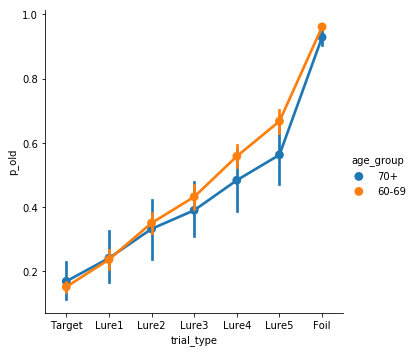

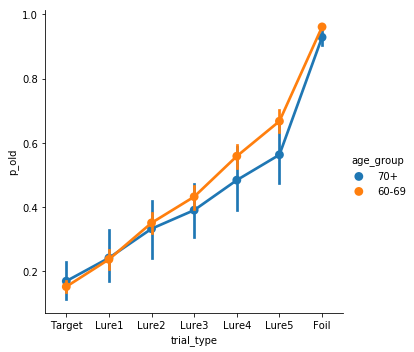

In [16]:
g=sns.catplot(x='trial_type', y='p_old', data=temp1, kind='point', hue='age_group', order= ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'])
g=sns.catplot(x='trial_type', y='p_old', data=temp1, kind='point', hue='age_group', order= ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'])

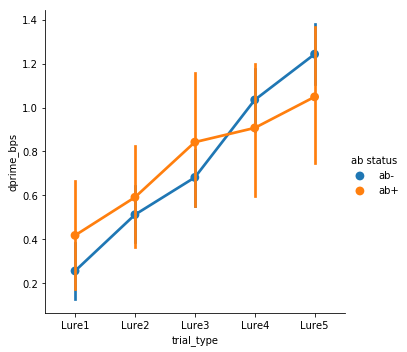

In [17]:
g=sns.catplot(x='trial_type', y='dprime_bps', data=temp1[(temp1['trial_type']!='Target') & (temp1['trial_type']!='Foil')], kind='point', hue='ab status', order= [ 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'])


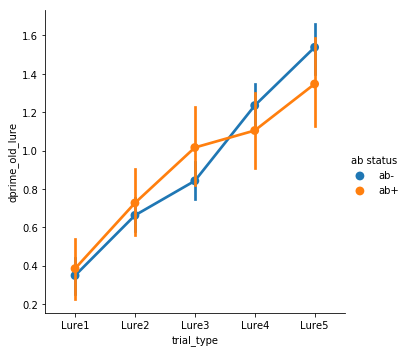

In [18]:
g=sns.catplot(x='trial_type', y='dprime_old_lure', data=temp1[(temp1['trial_type']!='Target') & (temp1['trial_type']!='Foil')], kind='point', hue='ab status', order= [ 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'])


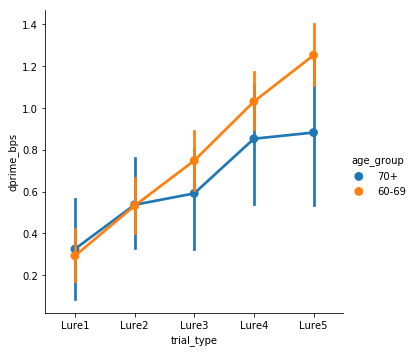

In [19]:
g=sns.catplot(x='trial_type', y='dprime_bps', data=temp1[(temp1['trial_type']!='Target') & (temp1['trial_type']!='Foil')], kind='point', hue='age_group', order= [ 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'])


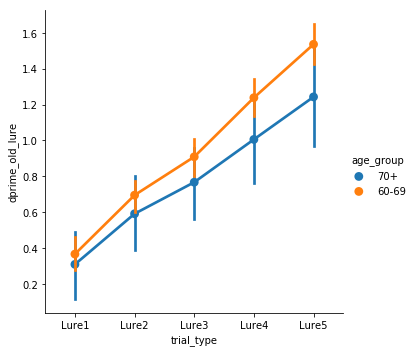

In [20]:
g=sns.catplot(x='trial_type', y='dprime_old_lure', data=temp1[(temp1['trial_type']!='Target') & (temp1['trial_type']!='Foil')], kind='point', hue='age_group', order= [ 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'])


In [21]:
print(summ_data)

        pidn trial_type  num_trials  num_correct  prop_correct  num_nr  \
0      449.0     Target        58.0         55.0      0.948276     5.0   
1      449.0       Foil        60.0         53.0      0.883333     3.0   
2      449.0      Lure1        11.0          1.0      0.090909     1.0   
3      449.0      Lure2        13.0          2.0      0.153846     0.0   
4      449.0      Lure3        13.0          1.0      0.076923     0.0   
5      449.0      Lure4        11.0          3.0      0.272727     2.0   
6      449.0      Lure5         8.0          2.0      0.250000     4.0   
7      456.0     Target        61.0         50.0      0.819672     2.0   
8      456.0       Foil        58.0         42.0      0.724138     6.0   
9      456.0      Lure1        11.0          0.0      0.000000     0.0   
10     456.0      Lure2        13.0          1.0      0.076923     0.0   
11     456.0      Lure3        12.0          4.0      0.333333     1.0   
12     456.0      Lure4        12.0   

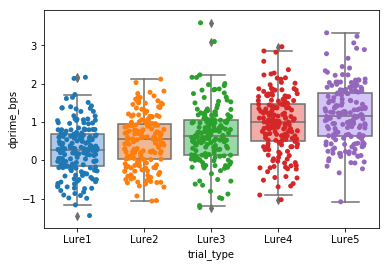

In [22]:
g=sns.boxplot(x='trial_type', y='dprime_bps', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')], palette='pastel')
g=sns.stripplot(x='trial_type', y='dprime_bps', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')], jitter=.3)


In [23]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Lure1']['dprime_bps'], summ_data[summ_data['trial_type']=='Lure2']['dprime_bps'], summ_data[summ_data['trial_type']=='Lure3']['dprime_bps'], summ_data[summ_data['trial_type']=='Lure4']['dprime_bps'], summ_data[summ_data['trial_type']=='Lure5']['dprime_bps'])
print(fvalue, pvalue)

42.43739643544527 1.7745565847164552e-32


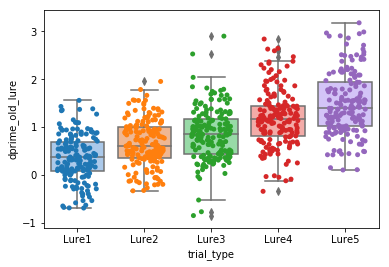

In [24]:
g=sns.boxplot(x='trial_type', y='dprime_old_lure', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')], palette='pastel')
g=sns.stripplot(x='trial_type', y='dprime_old_lure', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')], jitter=.3)


In [25]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Lure1']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure2']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure3']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure4']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure5']['dprime_old_lure'])
print(fvalue, pvalue)

110.03025564633971 1.4106425180796025e-75


In [26]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure2']['dprime_old_lure'])

Ttest_relResult(statistic=-7.856461415950216, pvalue=4.28805934969646e-13)

In [27]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure3']['dprime_old_lure'])

Ttest_relResult(statistic=-4.977707128056075, pvalue=1.5677830091041403e-06)

In [28]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure3']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure4']['dprime_old_lure'])

Ttest_relResult(statistic=-7.747714781352177, pvalue=8.088295635073727e-13)

In [29]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure4']['dprime_old_lure'], summ_data[summ_data['trial_type']=='Lure5']['dprime_old_lure'])

Ttest_relResult(statistic=-7.168522532357625, pvalue=2.2148477437345763e-11)

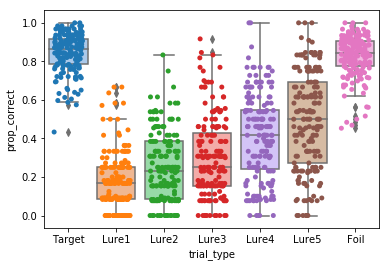

In [30]:
g=sns.boxplot(x='trial_type', y='prop_correct', data=summ_data, palette='pastel', order= ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'])
g=sns.stripplot(x='trial_type', y='prop_correct', data=summ_data, jitter=.3, order= ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'])

In [31]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Lure1']['corrected_hits'], summ_data[summ_data['trial_type']=='Lure2']['corrected_hits'], summ_data[summ_data['trial_type']=='Lure3']['corrected_hits'], summ_data[summ_data['trial_type']=='Lure4']['corrected_hits'], summ_data[summ_data['trial_type']=='Lure5']['corrected_hits'])
print(fvalue, pvalue)

95.94710912841956 2.2400650772144413e-67


In [32]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['corrected_hits'], summ_data[summ_data['trial_type']=='Foil']['corrected_hits'])

Ttest_relResult(statistic=-2.3373801151556006, pvalue=0.020584372364504416)

Text(0.5, 0, 'Proportion of Response')

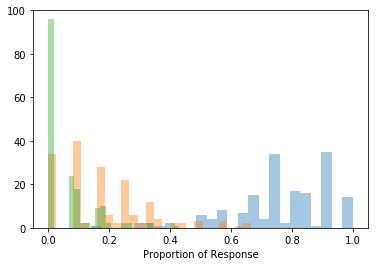

In [33]:
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure1')]['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure1')]['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure1')]['prop_misses'], kde=False, bins=25)
g.set(ylim=[0,100])
plt.xlabel('Proportion of Response')

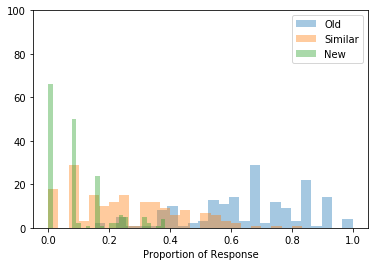

In [34]:
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure2')]['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure2')]['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure2')]['prop_misses'], kde=False, bins=25)
g.set(ylim=[0,100])
plt.xlabel('Proportion of Response')
plt.legend(['Old', 'Similar', 'New'])

Text(0.5, 0, 'Proportion of Response')

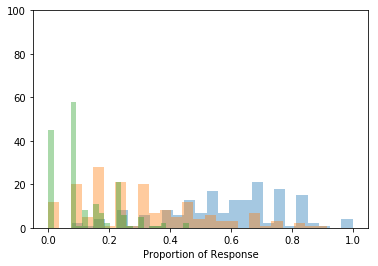

In [35]:
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure3')]['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure3')]['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure3')]['prop_misses'], kde=False, bins=25)
g.set(ylim=[0,100])
plt.xlabel('Proportion of Response')

Text(0.5, 0, 'Proportion of Response')

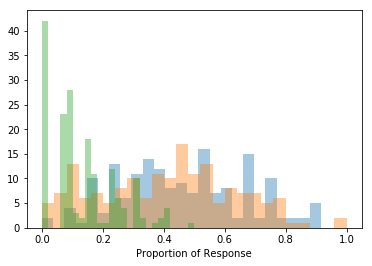

In [36]:
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure4')]['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure4')]['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure4')]['prop_misses'], kde=False, bins=25)
plt.xlabel('Proportion of Response')

In [37]:
bar_data= pd.DataFrame()

row=0

for pid in pd.unique(data_long['pidn']):
    bar_data.loc[row+18, 'pidn'] = pid
    bar_data.loc[row+18, 'Cond'] = 'Target'
    bar_data.loc[row+18, 'Resp'] = 'Old'
    bar_data.loc[row+18, 'num_resp'] = (len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T') & (data_long['Resp']==1)]))/(len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')]))
    
    bar_data.loc[row+19, 'pidn'] = pid
    bar_data.loc[row+19, 'Cond'] = 'Target'
    bar_data.loc[row+19, 'Resp'] = 'Sim'
    bar_data.loc[row+19, 'num_resp']= (len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T') & (data_long['Resp']==2)]))/(len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')]))
    
    bar_data.loc[row+20, 'pidn'] = pid
    bar_data.loc[row+20, 'Cond'] = 'Target'
    bar_data.loc[row+20, 'Resp'] = 'New'
    bar_data.loc[row+20, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T') & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='T')]))
    
    
    
    bar_data.loc[row, 'pidn'] = pid
    bar_data.loc[row, 'Cond'] = 'Lure1'
    bar_data.loc[row, 'Resp'] = 'Old'
    bar_data.loc[row, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==1)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1)]))
    
    
    bar_data.loc[row+1, 'pidn'] = pid
    bar_data.loc[row+1, 'Cond'] = 'Lure1'
    bar_data.loc[row+1, 'Resp'] = 'Sim'
    bar_data.loc[row+1, 'num_resp']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==2)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1)]))
    
    
    bar_data.loc[row+2, 'pidn'] = pid
    bar_data.loc[row+2, 'Cond'] = 'Lure1'
    bar_data.loc[row+2, 'Resp'] = 'New'
    bar_data.loc[row+2, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1) & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==1)]))
    
    
    bar_data.loc[row+3, 'pidn'] = pid
    bar_data.loc[row+3, 'Cond'] = 'Lure2'
    bar_data.loc[row+3, 'Resp'] = 'Old'
    bar_data.loc[row+3, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==1)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2)]))
    
    
    bar_data.loc[row+4, 'pidn'] = pid
    bar_data.loc[row+4, 'Cond'] = 'Lure2'
    bar_data.loc[row+4, 'Resp'] = 'Sim'
    bar_data.loc[row+4, 'num_resp']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==2)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2)]))
    
    
    bar_data.loc[row+5, 'pidn'] = pid
    bar_data.loc[row+5, 'Cond'] = 'Lure2'
    bar_data.loc[row+5, 'Resp'] = 'New'
    bar_data.loc[row+5, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2) & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==2)]))
    
    
    bar_data.loc[row+6, 'pidn'] = pid
    bar_data.loc[row+6, 'Cond'] = 'Lure3'
    bar_data.loc[row+6, 'Resp'] = 'Old'
    bar_data.loc[row+6, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==1)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3)]))
    
    
    bar_data.loc[row+7, 'pidn'] = pid
    bar_data.loc[row+7, 'Cond'] = 'Lure3'
    bar_data.loc[row+7, 'Resp'] = 'Sim'
    bar_data.loc[row+7, 'num_resp']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==2)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3)]))
    
   
    bar_data.loc[row+8, 'pidn'] = pid
    bar_data.loc[row+8, 'Cond'] = 'Lure3'
    bar_data.loc[row+8, 'Resp'] = 'New'
    bar_data.loc[row+8, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3) & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==3)]))
    
    
    bar_data.loc[row+9, 'pidn'] = pid
    bar_data.loc[row+9, 'Cond'] = 'Lure4'
    bar_data.loc[row+9, 'Resp'] = 'Old'
    bar_data.loc[row+9, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==1)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4)]))
    
    
    bar_data.loc[row+10, 'pidn'] = pid
    bar_data.loc[row+10, 'Cond'] = 'Lure4'
    bar_data.loc[row+10, 'Resp'] = 'Sim'
    bar_data.loc[row+10, 'num_resp']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==2)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4)]))
    
    
    bar_data.loc[row+11, 'pidn'] = pid
    bar_data.loc[row+11, 'Cond'] = 'Lure4'
    bar_data.loc[row+11, 'Resp'] = 'New'
    bar_data.loc[row+11, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4) & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==4)]))
    
    
    bar_data.loc[row+12, 'pidn'] = pid
    bar_data.loc[row+12, 'Cond'] = 'Lure5'
    bar_data.loc[row+12, 'Resp'] = 'Old'
    bar_data.loc[row+12, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==1)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5)]))
    
    
    bar_data.loc[row+13, 'pidn'] = pid
    bar_data.loc[row+13, 'Cond'] = 'Lure5'
    bar_data.loc[row+13, 'Resp'] = 'Sim'
    bar_data.loc[row+13, 'num_resp']= len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==2)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5)]))
    
    
    bar_data.loc[row+14, 'pidn'] = pid
    bar_data.loc[row+14, 'Cond'] = 'Lure5'
    bar_data.loc[row+14, 'Resp'] = 'New'
    bar_data.loc[row+14, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5) & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['LBin']==5)]))
    
    
    bar_data.loc[row+15, 'pidn'] = pid
    bar_data.loc[row+15, 'Cond'] = 'Foil'
    bar_data.loc[row+15, 'Resp'] = 'Old'
    bar_data.loc[row+15, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F') & (data_long['Resp']==1)])/(len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')]))
    
    
    bar_data.loc[row+16, 'pidn'] = pid
    bar_data.loc[row+16, 'Cond'] = 'Foil'
    bar_data.loc[row+16, 'Resp'] = 'Sim'
    bar_data.loc[row+16, 'num_resp']= len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F') & (data_long['Resp']==2)])/(len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')]))
    
    
    bar_data.loc[row+17, 'pidn'] = pid
    bar_data.loc[row+17, 'Cond'] = 'Foil'
    bar_data.loc[row+17, 'Resp'] = 'New'
    bar_data.loc[row+17, 'num_resp'] = len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F') & (data_long['Resp']==3)])/(len(data_long[(data_long['pidn']==pid) & (data_long['Cond']=='F')]))
    
    
    
    row+=21

In [38]:
print(bar_data)

        pidn    Cond Resp  num_resp
18     449.0  Target  Old  0.948276
19     449.0  Target  Sim  0.051724
20     449.0  Target  New  0.000000
0      449.0   Lure1  Old  0.909091
1      449.0   Lure1  Sim  0.090909
2      449.0   Lure1  New  0.000000
3      449.0   Lure2  Old  0.615385
4      449.0   Lure2  Sim  0.153846
5      449.0   Lure2  New  0.230769
6      449.0   Lure3  Old  0.923077
7      449.0   Lure3  Sim  0.076923
8      449.0   Lure3  New  0.000000
9      449.0   Lure4  Old  0.636364
10     449.0   Lure4  Sim  0.272727
11     449.0   Lure4  New  0.090909
12     449.0   Lure5  Old  0.500000
13     449.0   Lure5  Sim  0.250000
14     449.0   Lure5  New  0.250000
15     449.0    Foil  Old  0.100000
16     449.0    Foil  Sim  0.016667
17     449.0    Foil  New  0.883333
39     456.0  Target  Old  0.819672
40     456.0  Target  Sim  0.065574
41     456.0  Target  New  0.114754
21     456.0   Lure1  Old  0.818182
22     456.0   Lure1  Sim  0.000000
23     456.0   Lure1  New  0

Text(0, 0.5, 'Proportion Response')

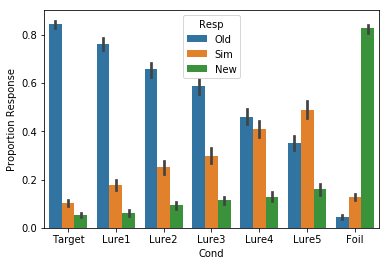

In [39]:
g=sns.barplot(x='Cond', y='num_resp', data=bar_data, hue='Resp', order=['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'])
plt.ylabel('Proportion Response')

In [40]:
fvalue, pvalue = stats.f_oneway(bar_data[bar_data['Cond']=='Target']['num_resp'], bar_data[bar_data['Cond']=='Lure1']['num_resp'], bar_data[bar_data['Cond']=='Lure2']['num_resp'], bar_data[bar_data['Cond']=='Lure3']['num_resp'], bar_data[bar_data['Cond']=='Lure4']['num_resp'], bar_data[bar_data['Cond']=='Lure5']['num_resp'], bar_data[bar_data['Cond']=='Foil']['num_resp'])
print(fvalue, pvalue)

-8.34681457942714e-33 nan


Text(0.5, 0, 'Proportion of Response')

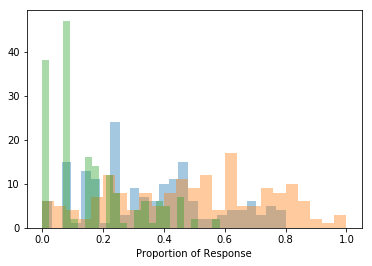

In [41]:
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure5')]['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure5')]['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[(summ_data['trial_type']=='Lure5')]['prop_misses'], kde=False, bins=25)
plt.xlabel('Proportion of Response')

In [42]:
print(summ_data)

        pidn trial_type  num_trials  num_correct  prop_correct  num_nr  \
0      449.0     Target        58.0         55.0      0.948276     5.0   
1      449.0       Foil        60.0         53.0      0.883333     3.0   
2      449.0      Lure1        11.0          1.0      0.090909     1.0   
3      449.0      Lure2        13.0          2.0      0.153846     0.0   
4      449.0      Lure3        13.0          1.0      0.076923     0.0   
5      449.0      Lure4        11.0          3.0      0.272727     2.0   
6      449.0      Lure5         8.0          2.0      0.250000     4.0   
7      456.0     Target        61.0         50.0      0.819672     2.0   
8      456.0       Foil        58.0         42.0      0.724138     6.0   
9      456.0      Lure1        11.0          0.0      0.000000     0.0   
10     456.0      Lure2        13.0          1.0      0.076923     0.0   
11     456.0      Lure3        12.0          4.0      0.333333     1.0   
12     456.0      Lure4        12.0   

In [43]:
## calculate the number of trials per bin without any exclusions
trial_data = pd.DataFrame()
row =0

for pt in pd.unique(data_long_with_nr['pidn']):
    trial_data.loc[row, 'pidn'] = pt
    trial_data.loc[row, 'l_1_trials'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pt) & (data_long_with_nr['LBin']==1)])
    trial_data.loc[row, 'l_2_trials'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pt) & (data_long_with_nr['LBin']==2)])
    trial_data.loc[row, 'l_3_trials'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pt) & (data_long_with_nr['LBin']==3)])
    trial_data.loc[row, 'l_4_trials'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pt) & (data_long_with_nr['LBin']==4)])
    trial_data.loc[row, 'l_5_trials'] = len(data_long_with_nr[(data_long_with_nr['pidn']==pt) & (data_long_with_nr['LBin']==5)])
    row+=1

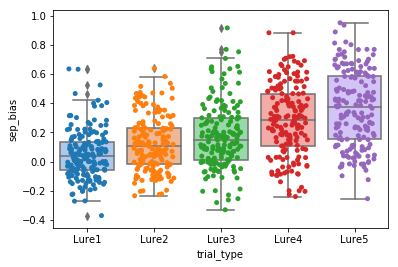

In [44]:
g=sns.boxplot(x='trial_type', y='sep_bias', data=summ_data[(summ_data['trial_type']!='Target') & (summ_data['trial_type']!='Foil')], palette='pastel', order= ['Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'])
g=sns.stripplot(x='trial_type', y='sep_bias', data=summ_data[(summ_data['trial_type']!='Target') & (summ_data['trial_type']!='Foil')], jitter=.3, order= ['Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'])


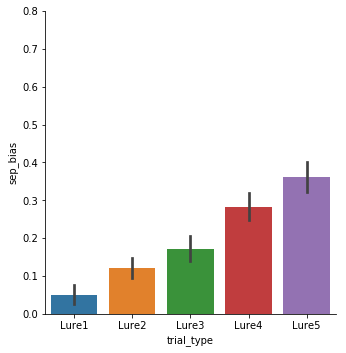

In [45]:
g=sns.catplot(x='trial_type', y='sep_bias', data=summ_data[(summ_data['trial_type']!='Target') & (summ_data['trial_type']!='Foil')], order= ['Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5'], kind='bar')
g.set(ylim=[0,.8])

In [46]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Lure1']['sep_bias'], summ_data[summ_data['trial_type']=='Lure2']['sep_bias'], summ_data[summ_data['trial_type']=='Lure3']['sep_bias'], summ_data[summ_data['trial_type']=='Lure4']['sep_bias'], summ_data[summ_data['trial_type']=='Lure5']['sep_bias'])
print(fvalue, pvalue)

56.099329350018756 5.1411630951691675e-42


In [47]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['sep_bias'], summ_data[summ_data['trial_type']=='Lure2']['sep_bias'])

Ttest_relResult(statistic=-6.319085415376045, pvalue=2.2283202299102385e-09)

In [48]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['sep_bias'], summ_data[summ_data['trial_type']=='Lure3']['sep_bias'])

Ttest_relResult(statistic=-3.9509916231002045, pvalue=0.00011389655775127853)

In [49]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure3']['sep_bias'], summ_data[summ_data['trial_type']=='Lure4']['sep_bias'])

Ttest_relResult(statistic=-7.03634824352876, pvalue=4.631126390149962e-11)

In [50]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure4']['sep_bias'], summ_data[summ_data['trial_type']=='Lure5']['sep_bias'])

Ttest_relResult(statistic=-5.246089245844886, pvalue=4.577041665503538e-07)

Text(6.799999999999997, 0.5, '1- p|old')

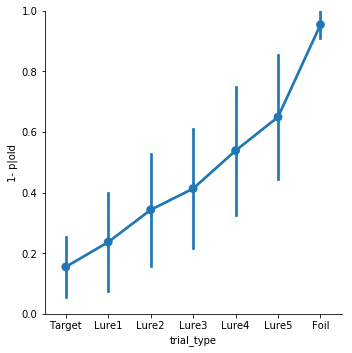

In [51]:

g=sns.catplot(x='trial_type', y='p_old', data=summ_data, order= ['Target','Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'], kind='point', ci='sd')
g.set(ylim=[0, 1])
plt.ylabel('1- p|old')

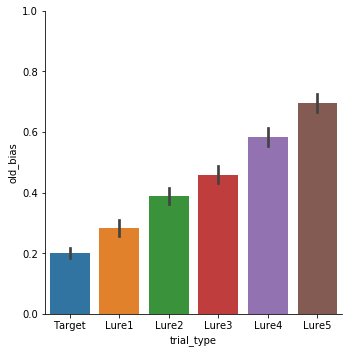

In [52]:
g=sns.catplot(x='trial_type', y='old_bias', data=summ_data[summ_data['trial_type']!='Foil'], kind='bar')
g.set(ylim=[0,1])

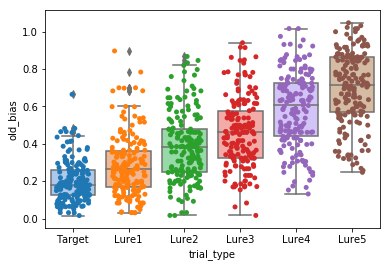

In [53]:
g=sns.boxplot(x='trial_type', y='old_bias', data=summ_data[summ_data['trial_type']!='Foil'], palette='pastel')
g=sns.stripplot(x='trial_type', y='old_bias', data=summ_data[summ_data['trial_type']!='Foil'], jitter=.3)

In [54]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Target']['old_bias'], summ_data[summ_data['trial_type']=='Lure1']['old_bias'], summ_data[summ_data['trial_type']=='Lure2']['old_bias'], summ_data[summ_data['trial_type']=='Lure3']['old_bias'], summ_data[summ_data['trial_type']=='Lure4']['old_bias'], summ_data[summ_data['trial_type']=='Lure5']['old_bias'])
print(fvalue, pvalue)

188.35068809197733 3.9816654382848745e-142


In [55]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['old_bias'], summ_data[summ_data['trial_type']=='Lure1']['old_bias'])

Ttest_relResult(statistic=-7.916057273259342, pvalue=3.023526538824854e-13)

In [56]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['old_bias'], summ_data[summ_data['trial_type']=='Lure2']['old_bias'])

Ttest_relResult(statistic=-8.099677926808438, pvalue=1.0230457344345106e-13)

In [57]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['old_bias'], summ_data[summ_data['trial_type']=='Lure3']['old_bias'])

Ttest_relResult(statistic=-5.139618206121229, pvalue=7.498127690436471e-07)

In [58]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure3']['old_bias'], summ_data[summ_data['trial_type']=='Lure4']['old_bias'])

Ttest_relResult(statistic=-7.809702105745042, pvalue=5.635999248092905e-13)

In [59]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure4']['old_bias'], summ_data[summ_data['trial_type']=='Lure5']['old_bias'])

Ttest_relResult(statistic=-7.203316752050093, pvalue=1.8218699481047513e-11)

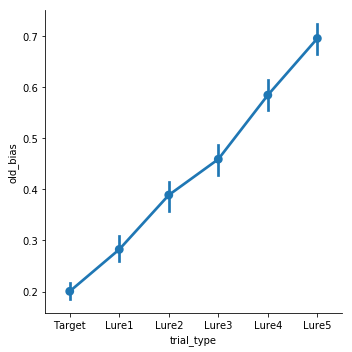

In [60]:
g=sns.catplot(x='trial_type', y='old_bias', data=summ_data[summ_data['trial_type']!='Foil'], kind='point')

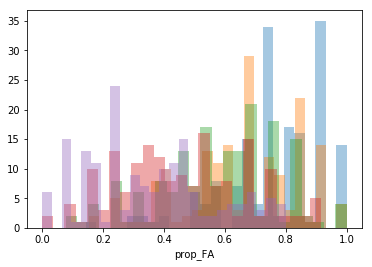

In [61]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_FA'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_FA'], kde=False, bins=25)

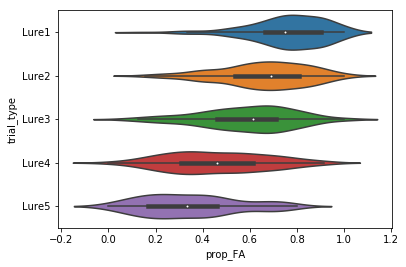

In [62]:
g=sns.violinplot(x='prop_FA', y='trial_type', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')])


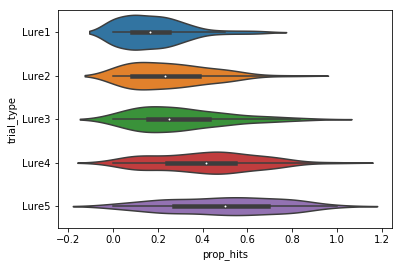

In [63]:
g=sns.violinplot(x='prop_hits', y='trial_type', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')])


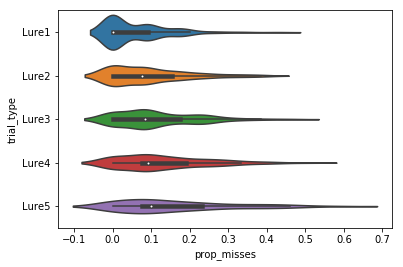

In [64]:
g=sns.violinplot(x='prop_misses', y='trial_type', data=summ_data[(summ_data['trial_type']=='Lure1') | (summ_data['trial_type']=='Lure2') | (summ_data['trial_type']=='Lure3') | (summ_data['trial_type']=='Lure4')| (summ_data['trial_type']=='Lure5')])


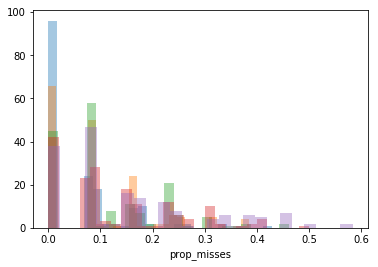

In [65]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_misses'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_misses'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_misses'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_misses'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_misses'], kde=False, bins=25)

[(0, 100)]

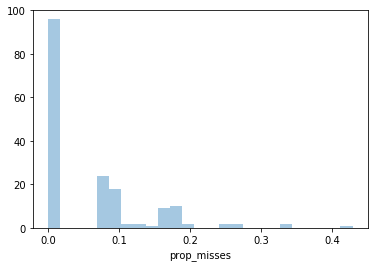

In [66]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_misses'], kde=False, bins=25)
g.set(ylim=[0,100])

[(0, 100)]

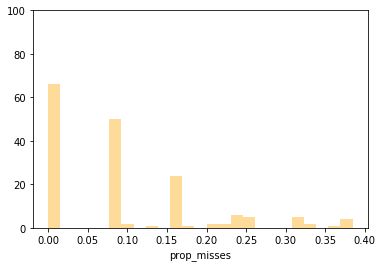

In [67]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_misses'], kde=False, bins=25, color='orange')
g.set(ylim=[0,100])

[(0, 100)]

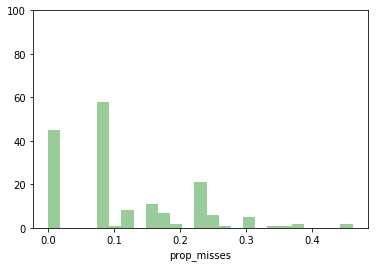

In [68]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_misses'], kde=False, bins=25, color='green')
g.set(ylim=[0,100])

[(0, 100)]

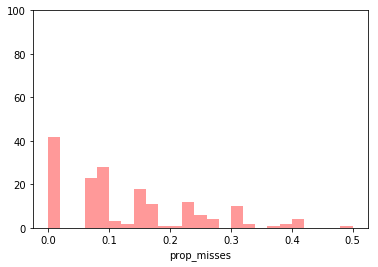

In [69]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_misses'], kde=False, bins=25, color='red')
g.set(ylim=[0,100])

[(0, 100)]

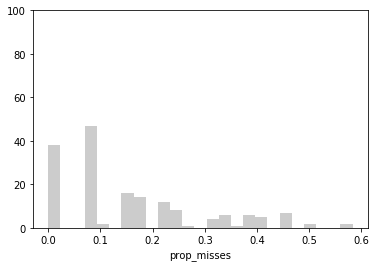

In [70]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_misses'], kde=False, bins=25, color='gray')
g.set(ylim=[0,100])

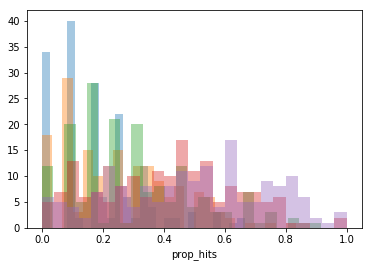

In [71]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_hits'], kde=False, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_hits'], kde=False, bins=25)


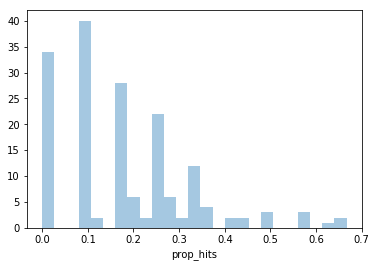

In [72]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_hits'], kde=False, bins=25)


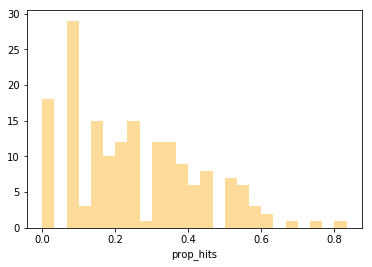

In [73]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_hits'], kde=False, bins=25, color='orange')


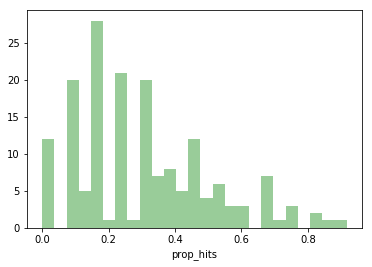

In [74]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_hits'], kde=False, bins=25, color='green')


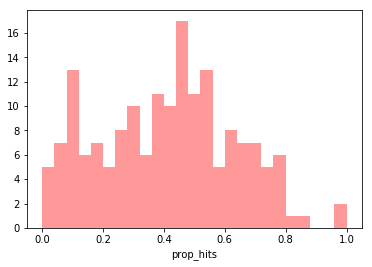

In [75]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_hits'], kde=False, bins=25, color='red')


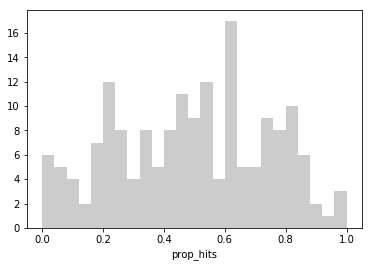

In [76]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_hits'], kde=False, bins=25, color='gray')

[(0, 100)]

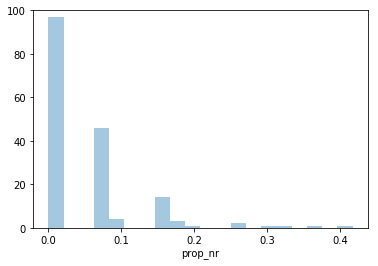

In [77]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_nr'], kde=0, bins=20)
g.set(ylim=[0, 100])

[(0, 100)]

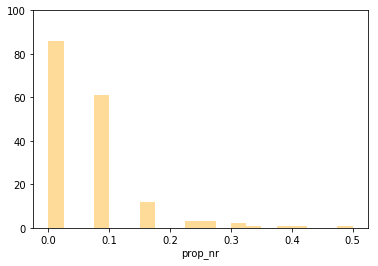

In [78]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_nr'], kde=0, bins=20, color='orange')
g.set(ylim=[0, 100])

[(0, 100)]

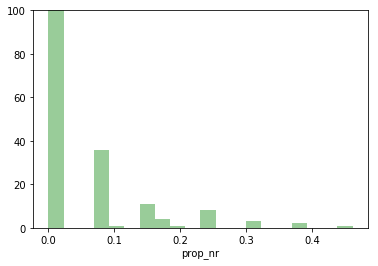

In [79]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_nr'], kde=0, bins=20, color='green')
g.set(ylim=[0, 100])

[(0, 100)]

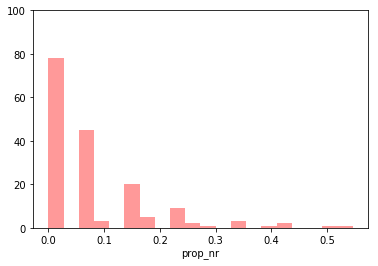

In [80]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_nr'], kde=0, bins=20, color = 'red')
g.set(ylim=[0, 100])

[(0, 100)]

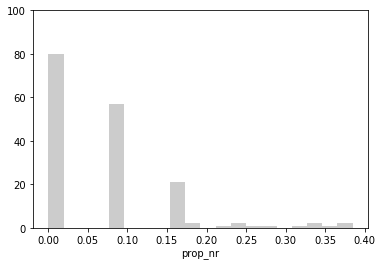

In [81]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_nr'], kde=0, bins=20, color = 'gray')
g.set(ylim=[0, 100])

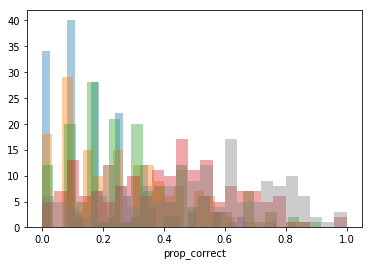

In [82]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_correct'], kde=0, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_correct'], kde=0, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_correct'], kde=0,  bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_correct'], kde=0, bins=25)
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_correct'], kde=0,  bins=25, color='gray')

[(0, 1)]

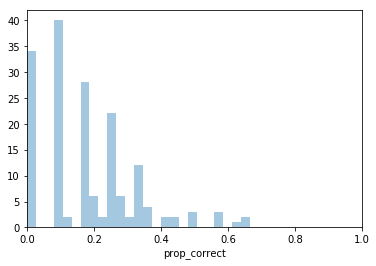

In [83]:
g=sns.distplot(summ_data[summ_data['trial_type']=='Lure1']['prop_correct'], kde=0, bins=25)
g.set(xlim=[0,1])

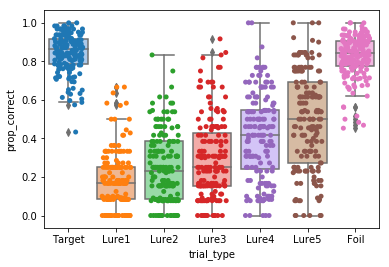

In [84]:
g=sns.boxplot(x='trial_type', y='prop_correct', data=summ_data, order = ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'], palette='pastel')
g=sns.stripplot(x='trial_type', y='prop_correct', data=summ_data, order = ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'], jitter=.3)

In [85]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Target']['prop_correct'], summ_data[summ_data['trial_type']=='Lure1']['prop_correct'], summ_data[summ_data['trial_type']=='Lure2']['prop_correct'], summ_data[summ_data['trial_type']=='Lure3']['prop_correct'], summ_data[summ_data['trial_type']=='Lure4']['prop_correct'], summ_data[summ_data['trial_type']=='Lure5']['prop_correct'], summ_data[summ_data['trial_type']=='Foil']['prop_correct'])
print(fvalue, pvalue)

374.5536067634033 6.043547460944416e-270


In [86]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_correct'], summ_data[summ_data['trial_type']=='Lure1']['prop_correct'])

Ttest_relResult(statistic=41.51395899391155, pvalue=6.739714374342041e-91)

In [87]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['prop_correct'], summ_data[summ_data['trial_type']=='Lure2']['prop_correct'])

Ttest_relResult(statistic=-6.319085415376045, pvalue=2.2283202299102385e-09)

In [88]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['prop_correct'], summ_data[summ_data['trial_type']=='Lure3']['prop_correct'])

Ttest_relResult(statistic=-3.950991623100203, pvalue=0.00011389655775127891)

In [89]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure3']['prop_correct'], summ_data[summ_data['trial_type']=='Lure4']['prop_correct'])

Ttest_relResult(statistic=-7.036348243528761, pvalue=4.631126390149912e-11)

In [90]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure4']['prop_correct'], summ_data[summ_data['trial_type']=='Lure5']['prop_correct'])

Ttest_relResult(statistic=-5.246089245844887, pvalue=4.5770416655035013e-07)

In [91]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure5']['prop_correct'], summ_data[summ_data['trial_type']=='Foil']['prop_correct'])

Ttest_relResult(statistic=-16.440543148769443, pvalue=5.763589447202892e-37)

In [92]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_correct'], summ_data[summ_data['trial_type']=='Foil']['prop_correct'])

Ttest_relResult(statistic=1.7851376472984049, pvalue=0.07602201852187149)

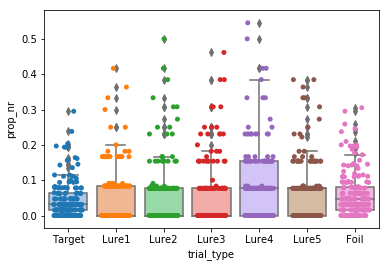

In [93]:
g=sns.boxplot(x='trial_type', y='prop_nr', data=summ_data, order = ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'], palette='pastel')
g=sns.stripplot(x='trial_type', y='prop_nr', data=summ_data, order = ['Target', 'Lure1', 'Lure2', 'Lure3', 'Lure4', 'Lure5', 'Foil'], jitter=.3)

In [94]:
fvalue, pvalue = stats.f_oneway(summ_data[summ_data['trial_type']=='Target']['prop_nr'], summ_data[summ_data['trial_type']=='Lure1']['prop_nr'], summ_data[summ_data['trial_type']=='Lure2']['prop_nr'], summ_data[summ_data['trial_type']=='Lure3']['prop_nr'], summ_data[summ_data['trial_type']=='Lure4']['prop_nr'], summ_data[summ_data['trial_type']=='Lure5']['prop_nr'], summ_data[summ_data['trial_type']=='Foil']['prop_nr'])
print(fvalue, pvalue)

3.5554612298726807 0.0017033752008130953


In [95]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_nr'], summ_data[summ_data['trial_type']=='Lure1']['prop_nr'])

Ttest_relResult(statistic=-2.090893130541727, pvalue=0.038024744939771885)

In [96]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_nr'], summ_data[summ_data['trial_type']=='Lure2']['prop_nr'])

Ttest_relResult(statistic=-3.1495002486997308, pvalue=0.001932504008652896)

In [97]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_nr'], summ_data[summ_data['trial_type']=='Lure3']['prop_nr'])

Ttest_relResult(statistic=-2.170359807123988, pvalue=0.03136691961892486)

In [98]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_nr'], summ_data[summ_data['trial_type']=='Lure4']['prop_nr'])

Ttest_relResult(statistic=-5.905218317273388, pvalue=1.8674206775895433e-08)

In [99]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Target']['prop_nr'], summ_data[summ_data['trial_type']=='Lure5']['prop_nr'])

Ttest_relResult(statistic=-3.9567213668854984, pvalue=0.00011142590111909553)

In [100]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['prop_nr'], summ_data[summ_data['trial_type']=='Lure2']['prop_nr'])

Ttest_relResult(statistic=-0.8547488944132827, pvalue=0.39389313269963855)

In [101]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['prop_nr'], summ_data[summ_data['trial_type']=='Lure3']['prop_nr'])

Ttest_relResult(statistic=-0.2728214990143215, pvalue=0.7853215526932874)

In [102]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['prop_nr'], summ_data[summ_data['trial_type']=='Lure4']['prop_nr'])

Ttest_relResult(statistic=-3.3273252526375643, pvalue=0.0010747267074968274)

In [103]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure1']['prop_nr'], summ_data[summ_data['trial_type']=='Lure5']['prop_nr'])

Ttest_relResult(statistic=-1.669682050680739, pvalue=0.0968226341839761)

In [104]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['prop_nr'], summ_data[summ_data['trial_type']=='Lure3']['prop_nr'])

Ttest_relResult(statistic=0.6082541841679784, pvalue=0.543830701225884)

In [105]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['prop_nr'], summ_data[summ_data['trial_type']=='Lure4']['prop_nr'])

Ttest_relResult(statistic=-2.66098119026136, pvalue=0.008537901027176425)

In [106]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure2']['prop_nr'], summ_data[summ_data['trial_type']=='Lure5']['prop_nr'])

Ttest_relResult(statistic=-0.8228073868146284, pvalue=0.411770199799147)

In [107]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure3']['prop_nr'], summ_data[summ_data['trial_type']=='Lure4']['prop_nr'])

Ttest_relResult(statistic=-3.147293824654572, pvalue=0.001946328503515344)

In [108]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure3']['prop_nr'], summ_data[summ_data['trial_type']=='Lure5']['prop_nr'])

Ttest_relResult(statistic=-1.439451414792963, pvalue=0.15186147675082112)

In [109]:
stats.ttest_rel(summ_data[summ_data['trial_type']=='Lure4']['prop_nr'], summ_data[summ_data['trial_type']=='Lure5']['prop_nr'])

Ttest_relResult(statistic=1.6747817992871679, pvalue=0.09581564120199547)

[(0, 1)]

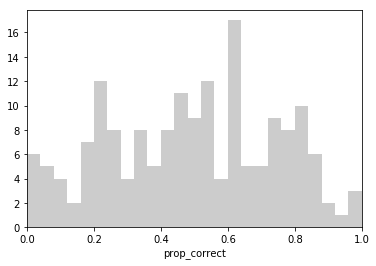

In [110]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_correct'], kde=0,  bins=25, color='gray')
g.set(xlim=[0,1])

[(0, 1)]

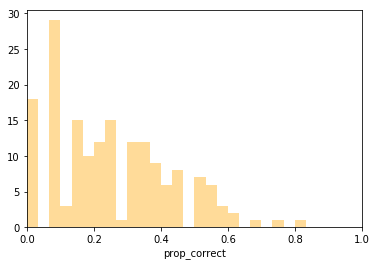

In [111]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure2']['prop_correct'], kde=0, bins=25, color='orange')
g.set(xlim=[0,1])


[(0, 1)]

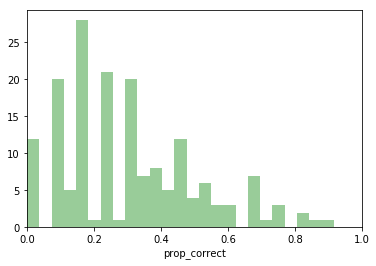

In [112]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure3']['prop_correct'], kde=0,  bins=25, color='green')
g.set(xlim=[0,1])


[(0, 1)]

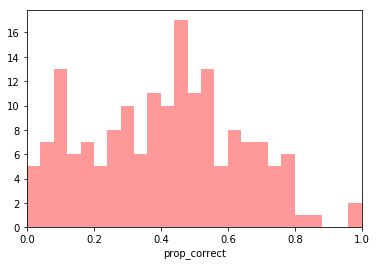

In [113]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure4']['prop_correct'], kde=0, bins=25, color='red')
g.set(xlim=[0,1])


[(0, 1)]

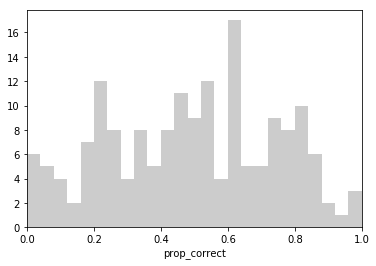

In [114]:

g=sns.distplot(summ_data[summ_data['trial_type']=='Lure5']['prop_correct'], kde=0,  bins=25, color='gray')
g.set(xlim=[0,1])

In [115]:
print(summ_data[summ_data['prop_correct']==0])
print(len(pd.unique(summ_data[summ_data['prop_correct']==0]['pidn'])))
print(pd.unique(summ_data[(summ_data['prop_correct']==0) & (summ_data['trial_type']=='Lure5')]['pidn']))

        pidn trial_type  num_trials  num_correct  prop_correct  num_nr  \
9      456.0      Lure1        11.0          0.0           0.0     0.0   
16     457.0      Lure1        12.0          0.0           0.0     0.0   
17     457.0      Lure2        13.0          0.0           0.0     0.0   
23     468.0      Lure1        12.0          0.0           0.0     0.0   
24     468.0      Lure2        13.0          0.0           0.0     0.0   
25     468.0      Lure3        13.0          0.0           0.0     0.0   
30     470.0      Lure1        12.0          0.0           0.0     0.0   
31     470.0      Lure2        12.0          0.0           0.0     1.0   
33     470.0      Lure4        12.0          0.0           0.0     1.0   
34     470.0      Lure5        13.0          0.0           0.0     0.0   
44     474.0      Lure1        12.0          0.0           0.0     0.0   
58     476.0      Lure1        11.0          0.0           0.0     1.0   
59     476.0      Lure2        13.0   

In [116]:
med_bin_data = data_long.groupby(['pidn', 'LBin']).median()

In [117]:
print(med_bin_data)

           Trial  Resp  Acc      RT
pidn LBin                          
449  0     101.0   1.0  1.0  1255.5
     1      92.0   1.0  0.0  1213.0
     2     114.0   1.0  0.0  1554.0
     3      72.0   1.0  0.0  1191.0
     4      82.0   1.0  0.0  1571.0
     5      68.5   1.5  0.0  1520.5
456  0      85.0   2.0  1.0  1360.0
     1     139.0   1.0  0.0  1236.0
     2     132.0   1.0  0.0  1525.0
     3      93.0   2.0  0.0  1305.5
     4     103.5   2.0  0.0  1487.5
     5     124.0   2.0  0.0  1533.0
457  0      99.5   2.0  1.0  1215.5
     1      86.5   1.0  0.0  1085.0
     2      95.0   1.0  0.0  1193.0
     3     108.0   1.0  0.0  1090.0
     4      74.0   2.0  0.0  1426.0
     5      81.0   2.0  0.0  1110.0
468  0      95.5   3.0  1.0  1063.0
     1      68.5   1.0  0.0   968.5
     2     102.0   1.0  0.0   978.0
     3     119.0   1.0  0.0   996.0
     4     100.0   1.0  0.0   979.0
     5     132.0   2.0  0.0  1188.0
470  0      98.5   1.0  1.0   999.5
     1      79.5   1.0  0.0 

In [118]:
resp_data= data_long.groupby(['pidn', 'LBin']).count()

In [119]:
print(data_long[(data_long['pidn']==470) & (data_long['Cond']=='L')])

     Trial   Img Cond  LBin  Resp  Acc    RT  pidn
729      1  087b    L     1     1    0  1274   470
732      5  132b    L     5     1    0   829   470
741     15  159b    L     1     1    0  1294   470
744     18  190b    L     4     3    0  1214   470
745     19  177b    L     1     1    0  1277   470
748     22  134b    L     3     1    0   892   470
750     24  156b    L     4     1    0  1450   470
752     26  191b    L     3     2    1  2016   470
754     28  008b    L     5     1    0  1491   470
755     29  185b    L     5     1    0  1447   470
759     33  069b    L     1     1    0  1021   470
761     35  165b    L     4     1    0  1635   470
763     37  189b    L     5     3    0  1359   470
764     38  167b    L     5     3    0   980   470
766     40  187b    L     4     1    0  1508   470
767     41  192b    L     5     1    0  1043   470
772     46  078b    L     3     1    0   999   470
776     50  005b    L     4     1    0   809   470
777     51  147b    L     5    

In [120]:
data_long.to_csv( '/Users/madisonhunt/Desktop/data_long.csv')

In [121]:
temp1.to_csv('/Users/madisonhunt/Desktop/lure_data.csv')